https://github.com/int-brain-lab/iblvideo/blob/c25e7572153c87a90683021490e010ce55140a88/prototyping/post_dlc/pupil_diameter.py

In [1]:
import os
import numpy as np
from one.api import ONE
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from video_functions import get_raw_and_smooth_pupil_dia, SNR, get_dlc_XYs_pupil
from one_functions_generic import subjects_interest_data, prepro

/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/one/webclient.py:127: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/one/webclient.py:127: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


### Get sessions from mice of interest

In [2]:
data_path =  '/home/ines/repositories/representation_learning_variability/Video/'
data_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability/Video/'
os.chdir(data_path)

mice = pickle.load(open("subject_intersection", "rb"))
naive_sessions = pickle.load(open("good_naive_sessions", "rb"))


### Parameters

In [3]:
event = 'stimOn_times'
event = 'feedback_times'
t_init = 0.5
t_end = 2
interval_length = 1500

### Loop through mice and plot for naif and proficient sessions

In [4]:
# Find paired sessions for each mouse
one = ONE()
for s, naif_session in enumerate(naive_sessions[7:8]):
    
    # Get mouse name
    session_details = one.list_datasets(naif_session, details=True)
    parts = session_details['session_path'][0].split('/')
    mouse_name = '/'.join(parts[2:3])
    
    # Get corresponding proficient sessions
    prof_sessions = subjects_interest_data([mouse_name], 'proficient', 'ephys')
    
    if len(prof_sessions) > 0:
        prof_sessions = prof_sessions['session'].unique()
        prof_session = prof_sessions[-1]

        # Get pupil diameter for each of the sessions

        pupil_dia_raw_prof, pupil_dia_smooth_prof = (
            get_raw_and_smooth_pupil_dia(prof_session, video_type='left'))
        times_prof, _ = get_dlc_XYs_pupil(one, prof_session, view='left', likelihood_thresh=0.9)

        pupil_dia_raw_naif, pupil_dia_smooth_naif = (
            get_raw_and_smooth_pupil_dia(naif_session, video_type='left'))
        times_naif, _ = get_dlc_XYs_pupil(one, naif_session, view='left', likelihood_thresh=0.9)
    
        # Get trials for corresponding sessions
        trials_naive = one.load_object(naif_session, obj='trials', namespace='ibl')
        naive_df = prepro(trials_naive.to_df())
        
        trials_prof = one.load_object(prof_session, obj='trials', namespace='ibl')
        prof_df = prepro(trials_prof.to_df())
        
        


/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/one/webclient.py:127: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)
/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/one/webclient.py:127: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


ConnectionError: HTTPSConnectionPool(host='alyx.internationalbrainlab.org', port=443): Max retries exceeded with url: /datasets?name=_ibl_subjectTrials.table.pqt&django=object_id%2C20086e93-a271-4a57-89fc-15604d8e92c0 (Caused by NewConnectionError('<urllib3.connection.HTTPSConnection object at 0x7fe028106a00>: Failed to establish a new connection: [Errno 60] Operation timed out'))

In [5]:
one = ONE()    
eid = '572a95d1-39ca-42e1-8424-5c9ffcb2df87'
video_type = 'left'

pupil_dia_raw_left, pupil_dia_smooth_left = (
    get_raw_and_smooth_pupil_dia(eid, video_type))
times, _ = get_dlc_XYs_pupil(one, eid, view='left', likelihood_thresh=0.9)

trials_mouse = one.load_object(eid, obj='trials', namespace='ibl')
trials_df = trials_mouse.to_df()


/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


SNR left 9.416464451351084


/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


SNR right 1.2205749258833056


In [20]:
trials_mouse = one.load_object(eid, obj='trials', namespace='ibl')
trials_df = trials_mouse.to_df()

/opt/anaconda3/envs/iblenv/lib/python3.9/site-packages/one/webclient.py:127: RuntimeWarning: Failed to connect, returning cached response
  warnings.warn('Failed to connect, returning cached response', RuntimeWarning)


Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.stimOff_times.069810f6-8211-4c58-957f-9fcba387dc7f.npy Bytes: 2840
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.goCueTrigger_times.304738a6-9753-4607-8110-d9e3fa2adfde.npy Bytes: 2840
Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.table.ba09a377-8df4-4b89-8ad4-c5dfb273182e.pqt Bytes: 32383


  0%|          | 0/0.00270843505859375 [00:00<?, ?it/s]

Downloading: /Users/ineslaranjeira/Downloads/FlatIron/cortexlab/Subjects/KS020/2020-02-07/001/alf/_ibl_trials.intervals_bpod.c01ec42d-9b40-40dc-9a98-57ed4c40dfcc.npy Bytes: 5552



100%|██████████| 0.00270843505859375/0.00270843505859375 [00:00<00:00,  5.42s/it]


100%|██████████| 0.00270843505859375/0.00270843505859375 [00:00<00:00,  3.76s/it]
100%|██████████| 0.0052947998046875/0.0052947998046875 [00:00<00:00,  1.72it/s]

100%|██████████| 0.030882835388183594/0.030882835388183594 [00:00<00:00,  4.83s/it]


In [39]:
processed_trials = prepro(trials_df)

In [55]:
np.diff(times)

array([0.016665  , 0.016665  , 0.01663167, ..., 0.01663167, 0.016665  ,
       0.01663167])

In [90]:
event = 'stimOn_times'
event = 'feedback_times'
t_init = 0.5
t_end = 2
interval_length = 1500

In [91]:
# Function parameters
position = pupil_dia_smooth_left
time = times[0:len(position)]
trials = trials_df

# Initialize dataframe
df = pd.DataFrame({'time':time, 'position':position})

onset_times = trials[event]

# Calculate max and min of the session for normalization
max_pupil = np.max(df['position'])
min_pupil = np.min(df['position'])

# Normalize pupil size
df['norm_position'] = (df['position'] - min_pupil) * 100 / (max_pupil - min_pupil)

# Start a matrix with #trials x # enough entries for the interval # TODO: need to fix interval length
stack = np.zeros((len(onset_times), interval_length)) * np.nan

for t, trial_onset in enumerate(onset_times):
    if np.isnan(trial_onset) == False:
        if len(df.loc[df['time'] > trial_onset-t_init, 'time']) > 0:

            # Calculate baseline (always in relation to StimOnTime)
            stim_on = trials['stimOn_times'][t]
            baseline = np.mean(df.loc[(df['time'] > stim_on-0.5) & (df['time'] <= stim_on), 'norm_position'])

            # Populate dataframe with useful trial-aligned information
            temp_stack = df.loc[(df['time']> trial_onset-t_init) & (df['time'] <= trial_onset+t_end), 'norm_position'] - baseline
            stack[t, 0:len(temp_stack)] = temp_stack

In [92]:
pupil_stack = pd.DataFrame(stack)
pupil_stack['feedback'] = list(processed_trials['correct'])
pupil_stack['choice'] = list(processed_trials['choice'])
pupil_stack['contrast'] = list(processed_trials['contrast'])
pupil_stack['side'] = list(np.sign(processed_trials['signed_contrast']))

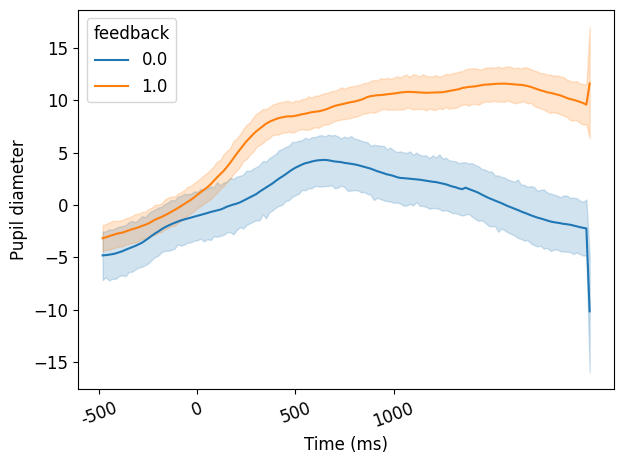

In [93]:
# TODO: need to fix time
import seaborn as sns
melted = pd.melt(pupil_stack, id_vars=['feedback', 'choice', 'contrast', 'side'], value_vars=np.array(pupil_stack.keys()[1:-4]))
plt.rc('font', size=12)

sns.lineplot(x='variable', y='value', hue='feedback', data=melted)
plt.xlabel('Time (ms)')
plt.ylabel('Pupil diameter')
plt.xticks([0, 30, 60, 90], [-500, 0, 500, 1000],
       rotation=20)
#plt.ylim([-.4, .4])
#plt.title('Proficient session')
plt.tight_layout()

In [21]:
def stack_trials(time, position, trials, event, t_init, t_end, interval_length):

    df = pd.DataFrame({'time':time, 'position':position})
    onset_times = trials[event]
    # Start a matrix with #trials x # wheel bins
    stack = np.zeros((len(onset_times), interval_length)) * np.nan

    for t, trial_onset in enumerate(onset_times):
        if np.isnan(trial_onset) == False:
            if len(df.loc[df['time'] > trial_onset, 'time']) > 0:
                trial_onset_index = df.loc[df['time'] > trial_onset, 'time'].reset_index()['index'][0]
                onset_position = df['position'][trial_onset_index]
                #trial_feedback = list(preprocessed_data['correct'])[t]

                # Populate dataframe with useful trial-aligned information
                stack[t, :] = df.loc[(df['time']> trial_onset-t_init) & (df['time'] <= trial_onset+t_end), 'position'] - onset_position 
    return stack

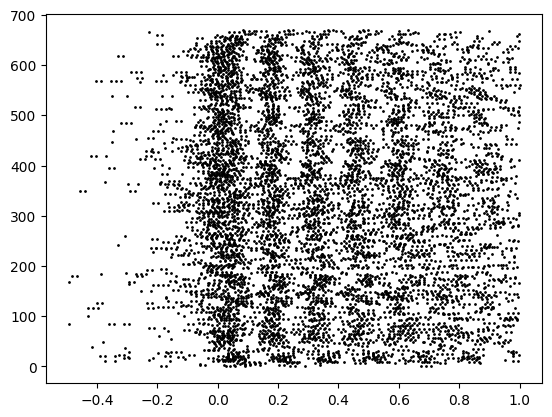

In [ ]:
        licks_naive = psth(naive_df, naive_lick_times, 1, 2, event='feedback_times')
        licks_prof = psth(prof_df, prof_lick_times, 1, 2, event='feedback_times')

        # Plot data
        fig, ax = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=True, figsize=[12, 7])
        # Naive session
        data = licks_naive
        num_trials = int(np.max(data['trial']))
        # Plotting the spikes
        for t, trial in enumerate(range(num_trials)):
            licks_correct = np.array(data.loc[(data['trial']==t) & (data['correct']==1), 'lick_times'])
            licks_incorrect = np.array(data.loc[(data['trial']==t) & (data['correct']==-1), 'lick_times'])
            ax[0].scatter(licks_correct, np.full_like(licks_correct, t), color='green', s=1)
            ax[0].scatter(licks_incorrect, np.full_like(licks_incorrect, t), color='red', s=1)

        ax[0].set_title('Naive session')
        ax[0].set_xlabel('Time from feedback')
        ax[0].set_ylim([0, 300])

        # Prof session
        data = licks_prof
        num_trials = int(np.max(data['trial']))
        # Plotting the spikes
        for t, trial in enumerate(range(num_trials)):
            licks_correct = np.array(data.loc[(data['trial']==t) & (data['correct']==1), 'lick_times'])
            licks_incorrect = np.array(data.loc[(data['trial']==t) & (data['correct']==-1), 'lick_times'])
            ax[1].scatter(licks_correct, np.full_like(licks_correct, t), color='green', s=1)
            ax[1].scatter(licks_incorrect, np.full_like(licks_incorrect, t), color='red', s=1)
        ax[1].set_title('Expert session')
        ax[1].set_xlabel('Time from feedback')
        ax[0].set_ylabel('Trial')